In [ ]:
# code to sort reactome pathways nicely into clusters

In [1]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pathways = pd.read_csv('https://download.reactome.org/94/ReactomePathways.txt', sep='\t', header=None)
pathways.columns = ['ID','name','species']
human_pathways = pathways[pathways.species=='Homo sapiens'].copy(deep=True)
id2name = human_pathways.set_index('ID').to_dict()['name']

In [3]:
hierarchy = pd.read_csv('https://download.reactome.org/94/ReactomePathwaysRelation.txt', sep='\t', header=None)
hierarchy.columns = ['parent','child']
hierarchy_hs = hierarchy[hierarchy.child.isin(id2name)].copy(deep=True)
hierarchy_hs

,parent,child
10942,R-HSA-109581,R-HSA-109606
10943,R-HSA-109581,R-HSA-169911
10944,R-HSA-109581,R-HSA-5357769
10945,R-HSA-109581,R-HSA-75153
10946,R-HSA-109582,R-HSA-140877
...,...,...
13778,R-HSA-9958790,R-HSA-427652
13779,R-HSA-9958790,R-HSA-433137
13780,R-HSA-9958863,R-HSA-352230
13781,R-HSA-9958863,R-HSA-428559


In [4]:
hierarchy_hs.to_csv('ReactomePathwaysHierarchyHuman.csv', index=False, encoding='utf-8')

In [5]:
hierarchy_hs['parent_name'] = hierarchy_hs['parent'].map(id2name)
hierarchy_hs['child_name']  = hierarchy_hs['child'].map(id2name)
hierarchy_hs.sort_values('parent_name')

,parent,child,parent_name,child_name
12451,R-HSA-5619084,R-HSA-5679090,ABC transporter disorders,Defective ABCG8 causes GBD4 and sitosterolemia
12452,R-HSA-5619084,R-HSA-5679096,ABC transporter disorders,Defective ABCG5 causes sitosterolemia
12455,R-HSA-5619084,R-HSA-5683177,ABC transporter disorders,Defective ABCC8 can cause hypo- and hyper-glyc...
12450,R-HSA-5619084,R-HSA-5679001,ABC transporter disorders,Defective ABCC2 causes DJS
12449,R-HSA-5619084,R-HSA-5678895,ABC transporter disorders,Defective CFTR causes cystic fibrosis
...,...,...,...,...
12893,R-HSA-72306,R-HSA-6787450,tRNA processing,tRNA modification in the mitochondrion
12892,R-HSA-72306,R-HSA-6785470,tRNA processing,tRNA processing in the mitochondrion
12891,R-HSA-72306,R-HSA-6784531,tRNA processing,tRNA processing in the nucleus
11692,R-HSA-199992,R-HSA-432722,trans-Golgi Network Vesicle Budding,Golgi Associated Vesicle Biogenesis


2841


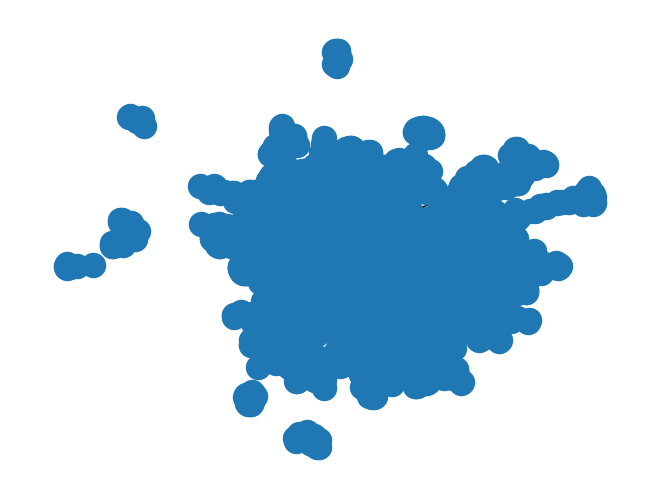

In [6]:
import networkx as nx
G = nx.Graph()
G.add_edges_from(
    [_ for _ in zip(hierarchy_hs.parent, hierarchy_hs.child)]
)
print(len(G.edges()))
nx.draw(G)

In [7]:
def pathway_distance(G,a,b):
    try:
        return len(nx.shortest_path(G, a, b))
    except nx.NetworkXNoPath as E:
        return 100

hierarchy_hs['distance'] = hierarchy_hs.apply(lambda row: pathway_distance(G, row.parent, row.child), axis=1)
hierarchy_hs.sort_values('distance')

,parent,child,parent_name,child_name,distance
10942,R-HSA-109581,R-HSA-109606,Apoptosis,Intrinsic Pathway for Apoptosis,2
12830,R-HSA-69580,R-HSA-69563,p53-Dependent G1/S DNA damage checkpoint,p53-Dependent G1 DNA Damage Response,2
12831,R-HSA-69613,R-HSA-69601,p53-Independent G1/S DNA Damage Checkpoint,Ubiquitin-Mediated Degradation of Phosphorylat...,2
12832,R-HSA-69615,R-HSA-69580,G1/S DNA Damage Checkpoints,p53-Dependent G1/S DNA damage checkpoint,2
12833,R-HSA-69615,R-HSA-69613,G1/S DNA Damage Checkpoints,p53-Independent G1/S DNA Damage Checkpoint,2
...,...,...,...,...,...
11891,R-HSA-2990846,R-HSA-3215018,SUMOylation,Processing and activation of SUMO,2
11892,R-HSA-2995410,R-HSA-2995383,Nuclear Envelope (NE) Reassembly,Initiation of Nuclear Envelope (NE) Reformation,2
11893,R-HSA-2995410,R-HSA-9615933,Nuclear Envelope (NE) Reassembly,Postmitotic nuclear pore complex (NPC) reforma...,2
11917,R-HSA-3229121,R-HSA-3814836,Glycogen storage diseases,Glycogen storage disease type XV (GYG1),2


In [8]:
all_pathways = list(set(pd.read_csv('results_combo.csv').stId))
all_distances = []
for a in all_pathways:
    for b in all_pathways:
        all_distances.append([a, b, pathway_distance(G,a,b)])
all_distances = pd.DataFrame(all_distances, columns=['pathwayA', 'pathwayB','distance'])
all_distances['pathwayA_name'] = '[' + all_distances.pathwayA + '] ' + all_distances.pathwayA.map(id2name)
all_distances['pathwayB_name'] = '[' + all_distances.pathwayB + '] ' + all_distances.pathwayB.map(id2name)
all_distances.tail()

,pathwayA,pathwayB,distance,pathwayA_name,pathwayB_name
5771,R-HSA-9716542,R-HSA-9772755,11,"[R-HSA-9716542] Signaling by Rho GTPases, Miro...",[R-HSA-9772755] Formation of WDR5-containing h...
5772,R-HSA-9716542,R-HSA-9675108,100,"[R-HSA-9716542] Signaling by Rho GTPases, Miro...",[R-HSA-9675108] Nervous system development
5773,R-HSA-9716542,R-HSA-9665249,100,"[R-HSA-9716542] Signaling by Rho GTPases, Miro...",[R-HSA-9665249] Resistance of ERBB2 KD mutants...
5774,R-HSA-9716542,R-HSA-4839726,100,"[R-HSA-9716542] Signaling by Rho GTPases, Miro...",[R-HSA-4839726] Chromatin organization
5775,R-HSA-9716542,R-HSA-9716542,1,"[R-HSA-9716542] Signaling by Rho GTPases, Miro...","[R-HSA-9716542] Signaling by Rho GTPases, Miro..."


In [9]:
len(all_pathways) * (len(all_pathways)-1)

5700

In [10]:
all_distances = all_distances.pivot(index='pathwayA_name', columns='pathwayB_name', values='distance')
all_distances.head()

pathwayB_name,[R-HSA-111465] Apoptotic cleavage of cellular proteins,[R-HSA-140342] Apoptosis induced DNA fragmentation,[R-HSA-1500931] Cell-Cell communication,[R-HSA-156827] L13a-mediated translational silencing of Ceruloplasmin expression,[R-HSA-156842] Eukaryotic Translation Elongation,[R-HSA-156902] Peptide chain elongation,[R-HSA-1640170] Cell Cycle,[R-HSA-1643685] Disease,[R-HSA-168273] Influenza Viral RNA Transcription and Replication,[R-HSA-176033] Interactions of Vpr with host cellular proteins,...,[R-HSA-9665737] Drug resistance in ERBB2 TMD/JMD mutants,[R-HSA-9675108] Nervous system development,[R-HSA-9711097] Cellular response to starvation,"[R-HSA-9716542] Signaling by Rho GTPases, Miro GTPases and RHOBTB3",[R-HSA-9759476] Regulation of Homotypic Cell-Cell Adhesion,[R-HSA-9764265] Regulation of CDH1 Expression and Function,[R-HSA-9764274] Regulation of Expression and Function of Type I Classical Cadherins,[R-HSA-9772755] Formation of WDR5-containing histone-modifying complexes,[R-HSA-9824446] Viral Infection Pathways,[R-HSA-9948299] Ribosome-associated quality control
pathwayA_name,,,,,,,,,,,,,,,,,,,,,
[R-HSA-111465] Apoptotic cleavage of cellular proteins,1,3,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
[R-HSA-140342] Apoptosis induced DNA fragmentation,3,1,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
[R-HSA-1500931] Cell-Cell communication,100,100,1,100,100,100,100,100,100,100,...,100,100,100,100,5,7,6,100,100,100
[R-HSA-156827] L13a-mediated translational silencing of Ceruloplasmin expression,100,100,100,1,4,5,100,100,100,100,...,100,100,100,100,100,100,100,100,100,4
[R-HSA-156842] Eukaryotic Translation Elongation,100,100,100,4,1,2,100,100,100,100,...,100,100,100,100,100,100,100,100,100,3


In [11]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

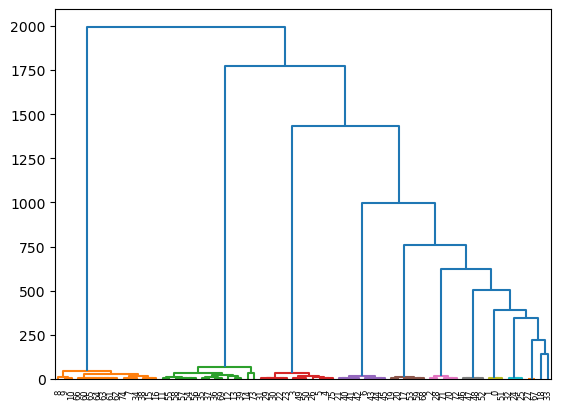

In [12]:
Z = linkage(all_distances, method='ward')
den = dendrogram(
    Z, 
    # truncate_mode='lastp'
    color_threshold=100
)
plt.show()

In [13]:
clusters = pd.DataFrame(([list(all_distances.index)[i] for i in den['leaves']], den['leaves_color_list'])).T
clusters.columns = ['name','cluster']
clusters

,name,cluster
0,[R-HSA-168273] Influenza Viral RNA Transcripti...,C1
1,[R-HSA-176033] Interactions of Vpr with host c...,C1
2,[R-HSA-180910] Vpr-mediated nuclear import of ...,C1
3,[R-HSA-9665737] Drug resistance in ERBB2 TMD/J...,C1
4,[R-HSA-9665230] Drug resistance in ERBB2 KD mu...,C1
...,...,...
71,[R-HSA-3247509] Chromatin modifying enzymes,C9
72,[R-HSA-422475] Axon guidance,C1
73,[R-HSA-9675108] Nervous system development,C1
74,[R-HSA-2408557] Selenocysteine synthesis,C0


In [14]:
clusters.to_csv('ReactomePathsClusters.csv', index=False)